In [19]:
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
from Bio.SVDSuperimposer import SVDSuperimposer
import nglview as nv

# # Path: pymdna/__init__.py, prototype of the package and atomic is not properly referenced in the package at genertors.py now I just explicitly define the path loction
# import pymdna as mdna
import sys
sys.path.append('/Users/thor/surfdrive/Projects/pymdna/')
import pymdna as mdna 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
traj = md.load('/Users/thor/surfdrive/Data/h-ns/BacterialChromatin/FI/0_k/2_ApT/dry_0.pdb')
traj = traj.atom_slice(traj.topology.select('resid 0 23'))# and not element symbol H'))

view = nv.show_mdtraj(traj)
view

NGLWidget()

In [30]:
fliplist = [0]
hoog = mdna.Hoogsteen(traj, fliplist, deg=180)
flipped_traj = hoog.traj
flipped_traj 

view = nv.show_mdtraj(flipped_traj)
view

NGLWidget()

In [7]:
def get_base_indices(traj, resid=0):

    # Define the atoms that belong to the nucleotide
    base_atoms = {'N9', 'N7', 'C8', 'C5', 'C4', 'N3', 'C2', 'N1', 
                'C6', 'C7','O6', 'N2', 'N6', 'O2', 'N4', 'O4', 'C5M',
                'H1','H2','H21','H22','H3','H41','H42','H5','H6','H61','H62','H71','H72','H73','H8'}
    
    # Select atoms that belong to the specified residue
    indices = traj.top.select(f'resid {resid}')
    offset = indices[0]  # Save the initial index of the residue

    # Create a subtrajectory containing only the specified residue
    subtraj = traj.atom_slice(indices)

    # Select the atoms that belong to the nucleotide
    sub_indices = subtraj.top.select(f'name {" ".join(base_atoms)}')
    # Return the indices of the atoms that belong to the nucleotide
    return sub_indices + offset


def select_atom_by_name(traj, name):
    # Select an atom by name returns shape (n_frames, 1, [x,y,z])
    return np.squeeze(traj.xyz[:,[traj.topology.select(f'name {name}')[0]],:],axis=1)


In [13]:
traj = md.load('/Users/thor/surfdrive/Data/h-ns/BacterialChromatin/FI/0_k/2_ApT/dry_0.pdb')

fliplist = [0, 6, 8]

# For each residue that needs to be mutated
for resid in fliplist:

    # Get the indices of the atoms that need to be transformed
    nucleobase_selection = get_base_indices(traj, resid=resid)

    # Get the coordinates of the atoms involved in the rotation
    c1_prime_coords = select_atom_by_name(traj, f'"C1\'" and resid {resid}')
    n9_coords = select_atom_by_name(traj, f"N9 and resid {resid}")

    # Calculate the Euler vector for the 180-degree rotation around the specified axis and normalize the axis vector
    rotation_axis = c1_prime_coords - n9_coords
    rotation_axis = rotation_axis / np.linalg.norm(rotation_axis)

    # Set the rotation angle to 180 degrees
    theta = np.deg2rad(180)  # Convert angle to radians

    # Update the xyz of the nucleobase in base_A.xyz using the rotation
    relative_positions = traj.xyz[:, nucleobase_selection, :] - n9_coords[:, None, :]

    # Apply the rotation to each atom's relative position
    rotated_positions = np.array([mdna.RigidBody.rotate_vector(v, rotation_axis[0], theta) for v in relative_positions[0]])

    # Translate the rotated positions back to the original coordinate system
    new_xyz = rotated_positions + n9_coords[:, None, :]

    # Update the coordinates in the trajectory
    traj.xyz[:, nucleobase_selection, :] = new_xyz


view = nv.show_mdtraj(traj)
view.clear()
view.add_representation('licorice', selection='all')
view


#     # Get the transformation for the local reference frames from the mutant to the target
#     mutant_reference = reference_frames[base]
#     target_reference = traj.atom_slice(traj.top.select(f'resid {resid}'))
#     rot, trans = self.get_base_transformation(mutant_reference, target_reference)

#     # Transform the mutant atoms to the local reference frame of the target
#     mutant_xyz = mutation_traj.xyz[:,mutant_indices,:]
#     new_xyz = np.dot(mutant_xyz, rot.T) + trans    

#     # Get the original xyz coordinates
#     xyz = traj.xyz 

#     # Split the xyz in 2 pieces, one before the indices that need to be replaced, and the indices after the indices that need to be replaced
#     xyz1 = xyz[:,:target_indices[0],:] 
#     xyz2 = xyz[:,target_indices[-1]+1:,]

#     # Update the topology
#     traj = self.update_mutant_topology(traj, target_indices, mutant_indices, base, resid, mutation_traj)

#     # Concatenate the new xyz with the original xyz
#     xyz = np.concatenate([xyz1, new_xyz, xyz2], axis=1)
#     traj.xyz = xyz

# # Return the mutated trajectory
# return traj

NGLWidget()

In [81]:
def select_atom_by_name(traj, name):
    # Select an atom by name returns shape (n_frames, 1, [x,y,z])
    return np.squeeze(traj.xyz[:,[traj.topology.select(f'name {name}')[0]],:],axis=1)

# Load the base A from the atomic library
loc = '../../pymdna/atomic/'
base_A = md.load(loc+'BDNA_G.pdb')
top = base_A.topology

# Get the coordinates of the atoms involved in the rotation
c1_prime_coords = select_atom_by_name(base_A, '"C1\'"')
n9_coords = select_atom_by_name(base_A, "N9")

# Calculate the Euler vector for the 180-degree rotation around the specified axis and normalize the axis vector
rotation_axis = c1_prime_coords - n9_coords
rotation_axis = rotation_axis / np.linalg.norm(rotation_axis)

# Set the rotation angle to 180 degrees
theta = np.deg2rad(180)  # Convert angle to radians

# Update the xyz of the nucleobase in base_A.xyz using the rotation
nucleobase_selection = top.select("(name =~ 'N[1-9]') or (name C1 C2 C3 C4 C5 C6 C7 C8 C9) or name O6")
relative_positions = base_A.xyz[:, nucleobase_selection, :] - n9_coords[:, None, :]

# Apply the rotation to each atom's relative position
rotated_positions = np.array([mdna.RigidBody.rotate_vector(v, rotation_axis[0], theta) for v in relative_positions[0]])

# Translate the rotated positions back to the original coordinate system
new_xyz = rotated_positions + n9_coords[:, None, :]

# Update the coordinates in the trajectory
base_A.xyz[:, nucleobase_selection, :] = new_xyz

# Proceed with visualization and saving...
base_A.save('BDNA_A_rotated.pdb')


In [82]:
view = nv.show_mdtraj(not_rotated)
view

NGLWidget()

In [83]:
rotated = md.load_pdb('BDNA_A_rotated.pdb')
not_rotated = md.load_pdb(loc+'BDNA_G.pdb')
merged = rotated.stack(not_rotated)
view = nv.show_mdtraj(merged)
view

NGLWidget()

In [32]:
loc = '../../pymdna/atomic/'
base_A = md.load(loc+'BDNA_A.pdb')

loc = '/Users/thor/surfdrive/Projects/pymdna/examples/non_canonical/pdbs/'
hg_dna = md.load(loc+'hg.pdb')
loc = '/Users/thor/surfdrive/Projects/pymdna/examples/non_canonical/'
base_H = md.load(loc+'BDNA_test_hs.pdb')
                
base_A, base_H

(<mdtraj.Trajectory with 1 frames, 21 atoms, 1 residues, without unitcells at 0x17f99ee50>,
 <mdtraj.Trajectory with 1 frames, 32 atoms, 1 residues, and unitcells at 0x17fa80a10>)

Compare HS-A with A nuceleobase, find atoms that are a good fit (aka fit planar nucleobases on top of each other)
`['N9', 'N3', 'C6', 'C4', 'C2', 'C5', 'N7']`

In [33]:
merge = base_A.stack(base_H)
view = nv.show_mdtraj(merge)
view

NGLWidget()

Now we use these atoms to move the non-canonical base to the same plane as the standard base A and compare the x,y,z coorindates of the atoms that are used for the ReferenceBase to construct the basis of the nucleobase. The fitted structure we can now add to the atomic directory ('BDNA_H.pdb'), and edit the `base_pair_map` `dict` in `generator.py` to encode the new base.

In [50]:
 
def get_rot_and_trans(subtraj_A,subtraj_B):
    """ fit only works now on a single frame (mdtraj returns xyz with shape (n_frames, atoms, xyz) 
        even for single frame trajs so hence the xyz[0]"""
    
    # load super imposer
    sup = SVDSuperimposer()

    # Set the coords, y will be rotated and translated on x
    x = subtraj_A.xyz[0]
    y = subtraj_B.xyz[0]
    sup.set(x, y)

    # Do the leastsquared fit
    sup.run()

    # Get the rms
    rms = sup.get_rms()

    # Get rotation (right multiplying!) and the translation
    rot, tran = sup.get_rotran()
    
    # now we have the instructions to rotate B on A
    return rot,tran,rms

def apply_superimposition(traj, rot, tran):
    
    # get xyz coordinates
    xyz = traj.xyz[0]
    
    # rotate subject on target
    new_xyz = np.dot(xyz, rot) + tran

    # replace coordinates of traj
    traj.xyz = new_xyz
    return traj

def fit_B_on_A(A, B, selection_A, selection_B):
    
    # create trajs containing only the selections
    subtraj_A = A.atom_slice(selection_A)
    subtraj_B = B.atom_slice(selection_B)

    # obtain instructions to rotate and translate B on A based on substraj structures
    rot, tran, rms = get_rot_and_trans(subtraj_A,subtraj_B)
    
    # do the superimposition of B on A and subsitute old with new xyz of B
    sup_B = apply_superimposition(B, rot, tran)

    # remove overlapping backbone atoms from B 
    selection_to_keep = [at.index for at in  B.top.atoms if at.index not in selection_B]

    new_B = sup_B
    return new_B, rms

def get_fit_indices(traj):
    residue = traj.top.residue(0)
    #print(residue, [at.name for at in residue._atoms])
    # res_indices = [at.index  for at in residue.atoms if at.name in ["P",'OP1','OP2',"C4'","C3'","C5'","O4'","O3'","C1\'"]]
    res_indices = [at.index  for at in residue.atoms if at.name in ["P",'N9','N6']]
    #res_indices = [at.index  for at in residue.atoms if at.name in ['N1','N9', 'N3', 'C6', 'C4', 'C2', 'C5', 'N7']]

    print(res_indices)
    return res_indices
            
def fit_bases(base_A, base_B):
    """ fit bases on trajectory """

    selection_A = get_fit_indices(base_A)
    selection_B = get_fit_indices(base_B)

    # Fits B on A
    return fit_B_on_A(A=base_A, B=base_B, selection_A=selection_A, selection_B=selection_B)


new_base_H, rms = fit_bases(base_A, base_H)
print(rms)
# Uncomment if you don't want hydrogens
#new_base_2AP.atom_slice(new_base_2AP.top.select('not element type hydrogen'))#.save('BDNA_P.pdb')
new_base_H.save_pdb('BDNA_test_hs.pdb')


res_A = mdna.ReferenceBase(base_A)
res_ref = mdna.ReferenceBase(new_base_H)

print(res_A.base_type, res_ref.base_type)
print(res_A.C1_coords, res_ref.C1_coords)
print(res_A.N_coords, res_ref.N_coords)
print(res_A.C_coords, res_ref.C_coords)


[0, 11, 16]
[0, 12, 18]
0.06056258455408126
purine purine
[[-0.2479  0.5346 -0.    ]] [[-0.2494803   0.5112035   0.02885651]]
[[-0.1291  0.4498 -0.    ]] [[-0.16768022  0.38900328  0.02707515]]
[[0.0071 0.2771 0.    ]] [[-0.01387873  0.23900259  0.01650716]]


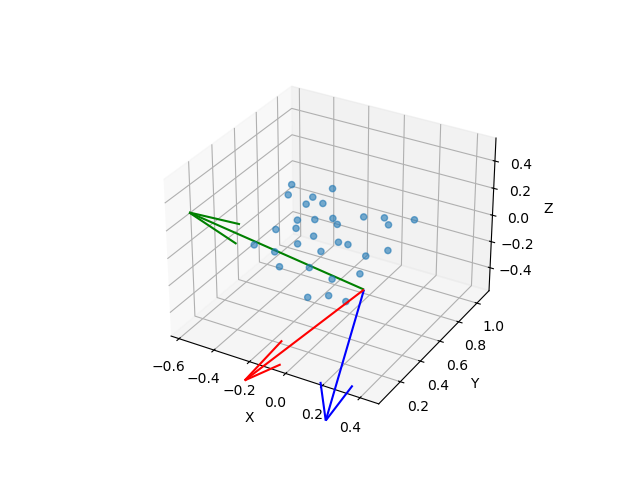

In [51]:
%matplotlib ipympl
res_ref.plot_baseframe()

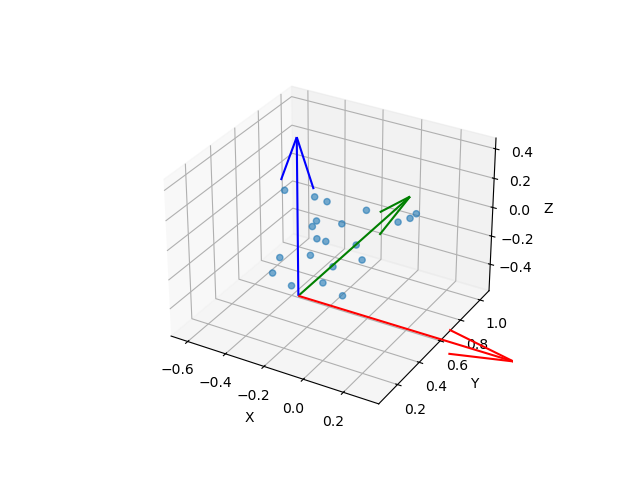

In [46]:
%matplotlib ipympl
res_A.plot_baseframe()

In [49]:
# Make control points
control_points = mdna.Shapes.line(length=1,num_points=100)

# Generate spline frames from control points
spline = mdna.SplineFrames(
    control_points=control_points, 
    frame_spacing=0.34,
    frame_tolerance=0.05,
    degree=3, 
    num_points = 10000,
    closed=False,
    verbose=False)

spline.twist_frames()
spline.frames.shape
sequence = 'H'*spline.frames.shape[0]
#sequence = 'HGGG'
dna = mdna.StructureGenerator(spline=spline,sequence=sequence)
traj = dna.traj
view = nv.show_mdtraj(traj)
view.clear()
view.add_representation('ball+stick', selection='all')  
view



Nan value found!
[nan nan nan]
++++++++++++++++++++++++
Nan value found!
[nan nan nan]
++++++++++++++++++++++++


NGLWidget()